# Import necessary modules

In [1]:
!pip install -U imbalanced-learn

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Processing
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.model_selection import RepeatedKFold
from imblearn.under_sampling import RandomUnderSampler

# Count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Requirement already up-to-date: imbalanced-learn in /opt/conda/lib/python3.6/site-packages (0.7.0)


# Prepare Data

In [2]:
df = pd.read_csv("clean_compiled_transcripts.csv", index_col = "Participant_ID")
df.head()

,Transcript,PHQ_Score,PHQ_Binary
Participant_ID,,,
300,good atlanta georgia um my parents um i love i...,2,0
301,thank you mmm k i good thank you i los angeles...,3,0
302,i fine yourself i los angeles california part ...,4,0
303,okay bout yourself california yeah oh well it ...,0,0
304,i good um los angeles california um cool weath...,6,0


## Convert transcripts to occurrence matrix (skip if you have the numpy data)

In [3]:
CV = CountVectorizer(min_df=3) # ignore terms that appear in less than 3 documents

## Split the dataset (skip if you have the numpy data)

In [4]:
X = CV.fit_transform(df.Transcript).toarray()
y = df.PHQ_Binary

In [5]:
def train_test(X, y, testfile='test_split_Depression_AVEC2017.csv'):
    test_participants = pd.read_csv(testfile)['participant_ID'].values
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    
    for i in range(y.shape[0]):
        participant_no = y.index[i]
        
        if participant_no in test_participants:
            X_test.append(X[i])
            y_test.append(y[participant_no])
        else:
            X_train.append(X[i])
            y_train.append(y[participant_no])
    
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

X_train, X_test, y_train, y_test = train_test(X, y)

In [6]:
RANDOM_STATE = 42

# the ratio of minority class to majority class will be 1 after resampling
us = RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)

X_train, y_train = us.fit_sample(X_train, y_train)

In [7]:
# shuffle the train data in unison because data is in order
# reduces poor performance during k-cross validation when sampling data

X_train, y_train = shuffle(X_train, y_train, random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((82, 2902), (45, 2902), (82,), (45,))

In [8]:
np.save("X_train_bow.npy", X_train)
np.save("X_test_bow.npy", X_test)
np.save("y_train_bow.npy", y_train)
np.save("y_test_bow.npy", y_test)

## Load dataset 

In [9]:
X_train = np.load("X_train_bow.npy")
X_test = np.load("X_test_bow.npy")
y_train = np.load("y_train_bow.npy")
y_test = np.load("y_test_bow.npy")

# More preprocessing

## Evaluation metrics
Some considerations in evaluation metrics when deciding our model.
1. In our use case, it is more important to have high sensitivity as want to correctly identify as many depression cases out of all actual depression cases for early intervention. Predicting a non-depressed person as depressed is comparatively less severe, meaning we prioritize TPR (sensitivity) over FPR.
2. Hence we will focus on `f1 score` and `recall` for the positive class.

Note:
* Sensitivity = true positive rate = recall = TP / (TP + FN)
* Specificity = true negative rate = TN / (TN + FP)
* Fall out = false positive rate = FP / (FP + TN)
* Miss rate = false negative rate = FN / (FN + TP)

Metrics can be found on this [website](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [10]:
def evaluate_on_training_set(y_test, y_pred):
    print(y_pred)
    print(y_test)
    
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

## k cross 

In [11]:
def k_cross(input_model, X=X_train, y=y_train, k=10, n=1, random_state=RANDOM_STATE):
    f1_scores = []
    recall_scores = []
    rkf = RepeatedKFold(n_splits=k, n_repeats=n, random_state=RANDOM_STATE)
        
    for train_index, val_index in rkf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
                
        model = clone(input_model) # prevents incremental fitting
        model.fit(X_train, y_train) 
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        recall = recall_score(y_val, y_pred)
        recall_scores.append(recall)
        
    return f1_scores, recall_scores

## Evaluate model

In [12]:
def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

# Model Implementation

## Gaussian Naive Bayes 

f1 mean score: 0.41468253968253965
recall mean score: 0.5216666666666667
[1 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 0 1 1
 0 0 1 1 1 1 0 0]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.4953917050691244
              precision    recall  f1-score   support

           0       0.68      0.42      0.52        31
           1       0.31      0.57      0.40        14

    accuracy                           0.47        45
   macro avg       0.50      0.50      0.46        45
weighted avg       0.57      0.47      0.48        45

Confusion Matrix: 
 [[13 18]
 [ 6  8]]


GaussianNB()

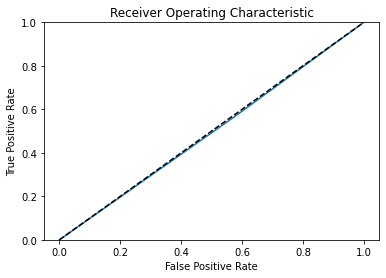

In [13]:
nb_model = GaussianNB()

f1_scores, recall_scores = k_cross(nb_model)

print(f"f1 mean score: {np.mean(f1_scores)}")
print(f"recall mean score: {np.mean(recall_scores)}")

evaluate_model(nb_model)

## Logistic Regression 

best scores: f1 = 0.637164502164502, recall = 0.6883333333333334
[1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1
 1 1 0 0 1 1 1 1]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.6670506912442395
              precision    recall  f1-score   support

           0       0.85      0.55      0.67        31
           1       0.44      0.79      0.56        14

    accuracy                           0.62        45
   macro avg       0.65      0.67      0.62        45
weighted avg       0.72      0.62      0.63        45

Confusion Matrix: 
 [[17 14]
 [ 3 11]]


LogisticRegression(C=1000000, n_jobs=3)

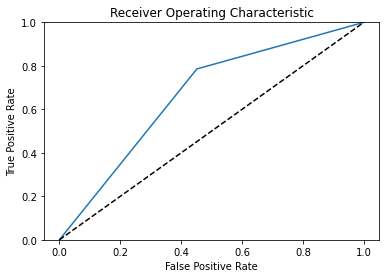

In [14]:
def find_best_logreg_model(power):
    best_f1_model = None
    best_f1 = -1
    best_recall = -1
    
    for i in range(power + 1):
        model = LogisticRegression(n_jobs=3, C=10**i)
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            best_f1 = f1
            best_recall = recall
            best_f1_model = model
    
    print(f"best scores: f1 = {best_f1}, recall = {best_recall}")
    
    return best_f1_model

best_logreg_f1_model = find_best_logreg_model(6)
evaluate_model(best_logreg_f1_model)

## Decision Tree

best scores: f1 = 0.5624963924963925, recall = 0.5750000000000001
[0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1
 1 1 1 0 1 1 1 1]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.48271889400921664
              precision    recall  f1-score   support

           0       0.67      0.32      0.43        31
           1       0.30      0.64      0.41        14

    accuracy                           0.42        45
   macro avg       0.48      0.48      0.42        45
weighted avg       0.55      0.42      0.43        45

Confusion Matrix: 
 [[10 21]
 [ 5  9]]


DecisionTreeClassifier(max_depth=3, min_samples_leaf=12, random_state=42)

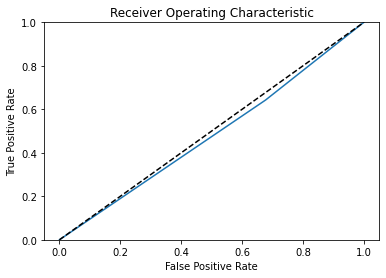

In [15]:
def find_best_tree_model(upper_depth, upper_leaf):
    best_f1_model = None
    best_f1 = -1
    best_recall = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, min_samples_leaf=leaf) 
            
            f1_scores, recall_scores = k_cross(model)
            f1 = np.mean(f1_scores)
            recall = np.mean(recall_scores)
            
            if f1 > best_f1:
                best_f1 = f1
                best_recall = recall
                best_f1_model = model
    
    print(f"best scores: f1 = {best_f1}, recall = {best_recall}")
    
    return best_f1_model

best_tree_f1_model = find_best_tree_model(20, 30)
evaluate_model(best_tree_f1_model)

## Random Forest

best scores: f1 = 0.5293867243867245, recall = 0.46833333333333327
[0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0
 0 0 1 0 1 1 0 0]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.6670506912442395
              precision    recall  f1-score   support

           0       0.85      0.55      0.67        31
           1       0.44      0.79      0.56        14

    accuracy                           0.62        45
   macro avg       0.65      0.67      0.62        45
weighted avg       0.72      0.62      0.63        45

Confusion Matrix: 
 [[17 14]
 [ 3 11]]


RandomForestClassifier(n_estimators=29, random_state=42)

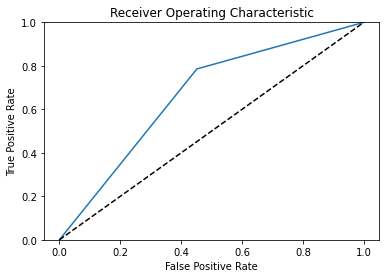

In [16]:
def find_best_forest_model(n_estimators):
    best_f1_model = None
    best_f1 = -1
    best_recall = -1
    
    for estimator in range(1, n_estimators + 1):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=estimator) 
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            best_f1 = f1
            best_recall = recall
            best_f1_model = model
    
    print(f"best scores: f1 = {best_f1}, recall = {best_recall}")
    
    return best_f1_model

best_forest_f1_model = find_best_forest_model(30)
evaluate_model(best_forest_f1_model)

## SVM with grid search

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 173 out of 180 | elapsed:    2.9s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    2.9s finished


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 132 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


f1 mean score: 0.5787878787878787
recall mean score: 0.7366666666666667
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    3.5s finished


[1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 0 0 1 1 1 0]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.5933179723502304
              precision    recall  f1-score   support

           0       0.89      0.26      0.40        31
           1       0.36      0.93      0.52        14

    accuracy                           0.47        45
   macro avg       0.62      0.59      0.46        45
weighted avg       0.72      0.47      0.44        45

Confusion Matrix: 
 [[ 8 23]
 [ 1 13]]
Best SVM parameters: {'C': 1, 'degree': 5, 'kernel': 'poly'}


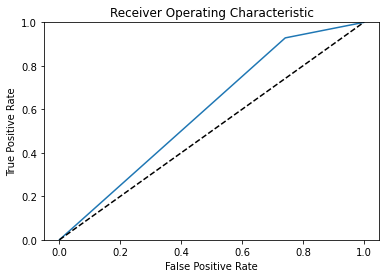

In [17]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [3, 4, 5], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

svm_model_cv = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='f1', verbose=1, n_jobs=4)

f1_scores, recall_scores = k_cross(svm_model_cv)

print(f"f1 mean score: {np.mean(f1_scores)}")
print(f"recall mean score: {np.mean(recall_scores)}")

best_svm_model = evaluate_model(svm_model_cv)
print(f"Best SVM parameters: {best_svm_model.best_params_}")